In [97]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

from environments import OctorotorEnvSelector
from systems.pid_agent import PIDAgent
from multirotor.helpers import DataLog
from stable_baselines3 import PPO
from parameters import pid_params
from trajectories import nasa_wp, square_100, circle_100

In [98]:
def get_tte(initial_pos: tuple, waypoints: np.ndarray, x: np.ndarray, y:np.ndarray, z:np.ndarray) -> np.ndarray:
        """
        Calculates the trajectory tracking error. 
        The distance between the current point and the vector between previous and next wp. Uses ||v1 x v2|| / ||v1||.

        Parameters
        ----------
        initial_pos : tuple  
            the initial position of the UAV.
        waypoints : np.ndarray 
            the reference positions at each point in time.
        x : np.ndarray 
            the x positions of the UAV.
        y : np.ndarray 
            the y positions of the UAV.
        z : np.ndarray
            the z positions of the UAV.

        Returns
        -------
        np.ndarray 
            the trajectory tracking error at each point in time.
        """
        ttes = []
        prev = initial_pos
        for i, waypoint in enumerate(waypoints):
            if i > 0 and not np.array_equal(waypoints[i-1], waypoints[i]):
                prev = waypoints[i-1]

            v1 = waypoint - prev
            v2 = np.array([x[i],y[i],z[i]]) - prev
            tte = np.linalg.norm(np.cross(v1, v2)) / (np.linalg.norm(v1) + 1e-6)
            ttes.append(tte)
                
        return np.array(ttes)

In [121]:
current_flight = 'bugatti_712_high'

In [122]:
real_data = pd.read_csv(f'../../uav-controller/model_data/{current_flight}.csv')

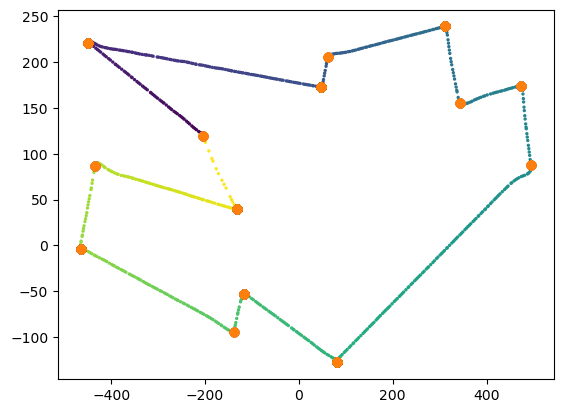

In [123]:
plt.scatter(real_data['x_np'], real_data['y_np'], s=2, c=range(len(real_data)))
plt.scatter(real_data['xwp'], real_data['ywp'])
plt.scatter(real_data['xwp'], real_data['ywp'])

In [124]:
real_wps = np.concatenate([[real_data['xwp'], real_data['ywp']]]).T
changes = np.any(np.diff(real_wps, axis=0) !=0, axis=1)
changes = np.concatenate(([True], changes))
real_wps = real_wps[changes]

In [125]:
real_wps

array([[-204.36671105,  119.86331763],
       [-449.58378987,  221.18402302],
       [  47.10427518,  173.29219918],
       [  61.57231562,  205.9512017 ],
       [ 310.57290723,  238.94999208],
       [ 343.21265271,  155.52694226],
       [ 473.01562201,  174.53001573],
       [ 495.54634917,   87.66338498],
       [  80.40134268, -127.63575879],
       [-117.14793402,  -52.5420418 ],
       [-138.52312807,  -94.53163366],
       [-464.64242793,   -3.42814235],
       [-433.89080934,   87.21493719],
       [-132.84810888,   39.76956286],
       [-204.36671105,  119.86331763],
       [-449.58378987,  221.18402302]])

In [198]:
# flight 1 run 1 E
# real_wps = np.array([[ 5.29574624e-02,  3.10434675e+01],
#        [ 3.73746646e+01,  3.33217872e+01],
#        [ 4.04270813e+01, -1.24157837e+01],
#        [ 8.54240264e+01, -1.20932301e+01],
#        [ 8.41830014e+01,  3.35936739e+01],
#        [ 1.29790945e+02,  3.47419056e+01],
#        [ 1.32069745e+02, -9.85477605e+00],
#        [-1.85262403e-02, -1.15024033e+01],
#        [ 5.29574624e-02,  3.10434675e+01]])

# flight 1 run 2 E
# real_wps = np.array([[  0.21737329,  24.26738043],
#         [ 37.53908042,  26.54570109],
#        [ 40.59149814, -19.19186976],
#        [ 85.58844327, -18.86931513],
#        [ 84.3474172 ,  26.81758883],
#        [129.95536076,  27.96582167],
#        [132.23416163, -16.63085997],
#        [  0.14589059, -18.27849036],
#        [  0.21737329,  24.26738043]])

real_wps = np.array([[-117.14793402,  -52.5420418 ],
       [-138.52312807,  -94.53163366],
       [-464.64242793,   -3.42814235],
       [-433.89080934,   87.21493719],
       [-132.84810888,   39.76956286],
       [-204.36671105,  119.86331763],
       [-449.58378987,  221.18402302],
       [-204.36671105,  119.86331763],
       [-449.58378987,  221.18402302],
       [  47.10427518,  173.29219918],
       [  61.57231562,  205.9512017 ],
       [ 310.57290723,  238.94999208],
       [ 343.21265271,  155.52694226],
       [ 473.01562201,  174.53001573],
       [ 495.54634917,   87.66338498],
       [  80.40134268, -127.63575879],
       [-117.14793402,  -52.5420418 ]])

real_wps = -real_wps

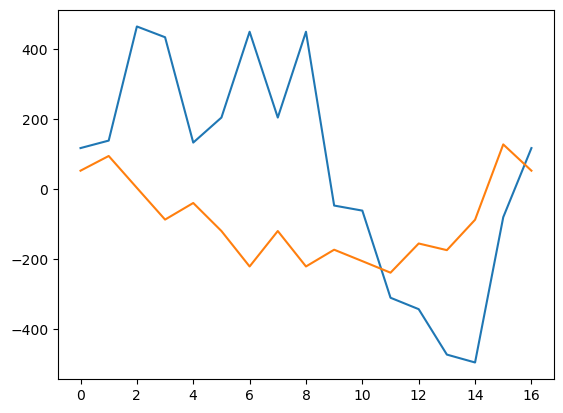

In [199]:
plt.plot(real_wps[:,0])
plt.plot(real_wps[:,1])

In [200]:
real_wps = np.hstack([real_wps, np.full((real_wps.shape[0], 1), 30)])

In [201]:
best_agent = PPO.load('./saved_models/higher_actions_noZ/96') 

In [202]:
pid_parameters = pid_params()

In [203]:
best_params = {'steps_u':50, 'scaling_factor':1, 'window_distance':23, 'pid_parameters':pid_parameters}

In [204]:
env_selector = OctorotorEnvSelector()

In [205]:
def run_trajectory(env_selector, wind_ranges: np.ndarray, agent, params, waypts):
    env = env_selector.get_env("lstm", params, wind_ranges, waypts, start_alt=30, has_turbulence=True)
    env.wp_options = [waypts]
    env.base_env.fault_type = None
    done = False
    state = np.array(env.reset(), dtype=np.float32)
    log = DataLog(env.base_env.vehicle, 
                      other_vars=('reward','next_wp', 'disturbance_pred', 'disturbance', 'lstm_input', 'agent_actions', 'observations', 'wind_x', 'wind_y',
                                  'inertial_x', 'inertial_y', 'inertial_z'))
    inputs = []
    while not done:
        action = agent.predict(state, deterministic=True)[0]
        state, reward, done, info = env.step(action)
        state = np.array(state, dtype=np.float32)
        log.log(reward=reward, next_wp=env.base_env.next_waypt, disturbance_pred=env.base_env.disturbance_pred, 
                disturbance=env.base_env.disturbance, lstm_input=env.base_env.lstm_input, agent_actions=action,
                observations=env.base_env.observed_state, wind_x=env.base_env.wind_x, wind_y=env.base_env.wind_y, 
                inertial_x=env.base_env.vehicle.inertial_velocity[0], inertial_y=env.base_env.vehicle.inertial_velocity[1], 
                inertial_z=env.base_env.vehicle.inertial_velocity[2])
        inputs.append(np.array(env.base_env.lstm_input))
        

    log.done_logging()
    return log, info, np.array(inputs)

In [206]:
x_wind = real_data['wind_x'][0]
y_wind = real_data['wind_y'][0]

In [207]:
log, info, inputs = run_trajectory(env_selector, [(x_wind,x_wind), (y_wind,y_wind), (0,0)], best_agent, best_params, real_wps)

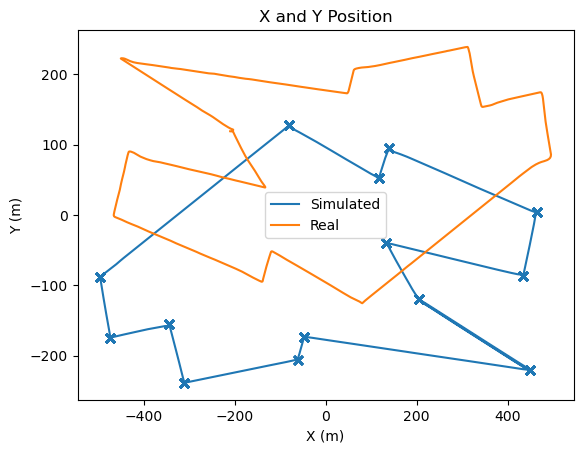

In [208]:
kept_idx = range(47, len(log.x))
plt.plot(log.x[kept_idx], log.y[kept_idx], label='Simulated')
plt.plot(real_data['x_np'], real_data['y_np'], label='Real')
plt.scatter(log.next_wp[:,0], log.next_wp[:,1], marker='x')
plt.xlabel("X (m)")
plt.ylabel("Y (m)")
plt.title("X and Y Position")
plt.legend()

In [209]:
ttes = get_tte((0,0,30), log.next_wp, log.x, log.y, log.z)

In [210]:
real_data.columns

Index(['Unnamed: 0', 'lon', 'lat', 'ecefx', 'ecefy', 'ecefz', 'vEcefx',
       'vEcefy', 'vEcefz', 'alt', 'trackNumber', 'hdg', 'time_boot_ms', 'roll',
       'pitch', 'yaw', 'rollspeed', 'pitchspeed', 'yawspeed', 'ref_vel',
       'delta_vel', 'total_vel', 'next_wps', 'x_np', 'y_np', 'time_diff',
       'xwp', 'ywp', 'zwp', 'vx', 'vy', 'vz', 'delta_x', 'delta_y', 'ref_vx',
       'ref_vy', 'tte', 'dist_x', 'dist_y', 'dist_z', 'wind_x', 'wind_y',
       'traj'],
      dtype='object')

In [211]:
def make_rl_df(log, ttes, kept_idx=None):

    if kept_idx is None:
        kept_idx = range(0, len(log.x))

    x_np = log.x[kept_idx]
    y_np = log.y[kept_idx] 
    alt = log.z[kept_idx]

    vx = log.inertial_x[kept_idx] 
    vy = log.inertial_y[kept_idx]
    vz = log.inertial_z[kept_idx]

    roll = log.roll[kept_idx] 
    pitch = log.pitch[kept_idx]
    yaw = log.yaw[kept_idx]

    rollspeed = log.angular_rate[kept_idx,0]
    pitchspeed = log.angular_rate[kept_idx,1]
    yawspeed = log.angular_rate[kept_idx,2]

    xwp = log.next_wp[kept_idx,0]
    ywp = log.next_wp[kept_idx,1]
    zwp = log.next_wp[kept_idx,2]

    delta_x = log.agent_actions[kept_idx,0]
    delta_y = log.agent_actions[kept_idx,1]

    ttes = ttes[kept_idx]

    dist_x = log.disturbance_pred[kept_idx,0]
    dist_y = log.disturbance_pred[kept_idx,1]
    dist_z = log.disturbance_pred[kept_idx,2]

    data = pd.DataFrame(np.vstack([x_np, y_np, alt, vx, vy, vz, roll, pitch, yaw, rollspeed, pitchspeed, yawspeed, 
                        xwp, ywp, zwp, delta_x, delta_y, ttes, dist_x, dist_y, dist_z]).T,
                        columns=['x_np', 'y_np', 'alt', 'vx', 'vy', 'vz', 'roll', 'pitch', 'yaw',
                        'rollspeed', 'pitchspeed', 'yawspeed', 'xwp', 'ywp', 'zwp',
                        'delta_x', 'delta_y', 'ttes', 'dist_x', 'dist_y', 'dist_z'])

    return data

In [212]:
rl_df = make_rl_df(log, ttes, kept_idx=kept_idx)

In [213]:
rl_df.to_csv(f'../../uav-controller/model_data/sim_reverse_{current_flight}.csv')